In [1]:
# %% import package to use
import datatable
import pandas as pd
from IPython.display import display
import numpy as np
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
pd.set_option('display.max_columns', None)

df_results_rf = pd.read_csv('./grid_search/results_rf_reg.csv', index_col='Unnamed: 0')
df_results_linear = pd.read_csv('./grid_search/results_linear_reg.csv', index_col='Unnamed: 0')
df_results_elastic = pd.read_csv('./grid_search/results_elastic_reg.csv', index_col='Unnamed: 0')

rf_best_param = df_results_rf.loc[df_results_rf['rank_test_score'] == 1].iloc[-1]
linear_best_param = df_results_linear.loc[df_results_linear['rank_test_score'] == 1].iloc[-1]
elastic_best_param = df_results_elastic.loc[df_results_elastic['rank_test_score'] == 1].iloc[-1]


import pickle
with open('./grid_search/results_xg_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)
xg_best_param = df_results_xg[df_results_xg['mean_score'] == df_results_xg['mean_score'].max()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores']].reset_index(drop=True)



In [2]:
import pickle

#### XGBoost
with open('./grid_search/M_results_5_xg_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['mean_mse'] == df_results_xg['mean_mse'].min()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores', 'mse_loss']].reset_index(drop=True)

#### Random Forest
with open('./grid_search/M_results_5_rf_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_rf = pd.DataFrame()
for condition in results:
    df_results_rf = pd.concat((df_results_rf, pd.DataFrame(results[condition])), axis=0)
    
rf_best_param = df_results_rf[df_results_rf['mean_mse'] == df_results_rf['mean_mse'].min()][['n_estimators', 'criterion', 'min_samples_split', 'max_features', 'scores', 'mse_loss']].reset_index(drop=True)


#### Linear Regression
with open('./grid_search/M_results_5_linear_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_linear = pd.DataFrame()
for condition in results:
    df_results_linear = pd.concat((df_results_linear, pd.DataFrame(results[condition])), axis=0)
    
linear_best_param = df_results_linear[df_results_linear['mean_mse'] == df_results_linear['mean_mse'].min()][['normalize', 'scores', 'mse_loss']].reset_index(drop=True)


#### ElasticNet
with open('./grid_search/M_results_5_elastic_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_elastic = pd.DataFrame()
for condition in results:
    df_results_elastic = pd.concat((df_results_elastic, pd.DataFrame(results[condition])), axis=0)
    
elastic_best_param = df_results_elastic[df_results_elastic['mean_mse'] == df_results_elastic['mean_mse'].min()][['alpha', 'l1_ratio', 'selection', 'scores', 'mse_loss']].reset_index(drop=True)

In [3]:
# %% Load dataset
DATA_PATH = "/home/lkh256/Studio/VO2max_Prediction/Data"
df_init = datatable.fread(os.path.join(DATA_PATH, 'general_eq.csv'), encoding='utf-8-sig', na_strings=['', 'NA']).to_pandas()
df_init['SM_DATE'] = df_init['SM_DATE'].astype('datetime64')

print(df_init.isnull().sum())

df_init = df_init.fillna(df_init.median())

print("Number of samples = {}".format(len(df_init)))

# %% Check missings
print("Check their is any missing variables in dataset: \n", df_init.isnull().sum())

# %% Sort visit number and select rows to analysis
df_init['visit_num'] = df_init.groupby(['HPCID'])['SM_DATE'].apply(pd.Series.rank)
df_selected = df_init[(df_init['visit_num'] == 1) & (df_init['sex'] == 0)].reset_index(drop=True)
print("Number of eq case = {}".format(len(df_selected)))


feature_mask = ['AGE', 'BMI', 'rest_HR', 'MVPA']

# %%
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_selected,  
                                       random_state=1005, 
                                       stratify=df_selected['sex'], 
                                       test_size=0.2)

print("Train set size = {}".format(len(train_set)))
print("Test set size = {}".format(len(test_set)))

X_train = train_set[feature_mask].values
y_train = train_set['CRF'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['CRF'].values
dtest = xgb.DMatrix(X_test, label=y_test)


SM_DATE                  0
HPCID                    0
sex                      0
AGE                      0
percentage_fat           0
Height                   0
Weight                   0
BMI                      0
MVPA                     0
rest_HR                  0
Smoke                    0
CRF                      0
비만도                      0
Muscle_mass              0
복부지방율                    0
부종검사                     0
Muscle_mass(RA)          0
Muscle_mass(LA)          0
Muscle_mass(BODY)        0
Muscle_mass(RL)          0
Muscle_mass(LL)          0
체지방량                     0
체수분량                     0
제지방량                     0
CRP                   1099
CHOLESTEROL            203
TG                     203
max_heart_rate           0
BMI_cal                  0
ASMI                     0
VO2max                   0
death                    0
delta_time               0
Diabetes                 0
Hypertension             0
HTN_med                  0
Hyperlipidemia           0
H

## Random Forest

In [4]:
rf_best_param.head(1)

n_estimators criterion  min_samples_split max_features    scores  mse_loss
0           700       mse                  4         log2  0.154781  0.975555

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_split=4, n_estimators=700, n_jobs=-1, random_state=1004)

feature_mask = ['AGE', 'BMI', 'rest_HR', 'MVPA']

rf_reg.fit(train_set[feature_mask], train_set['CRF'])

print("Train R^2 Score : ", r2_score(y_pred=rf_reg.predict(train_set[feature_mask]), y_true=train_set['CRF']))
print("Test R^2 Score", r2_score(y_pred=rf_reg.predict(test_set[feature_mask]), y_true=test_set['CRF']))
print("\nTrain mse_loss : ", mean_squared_error(y_pred=rf_reg.predict(train_set[feature_mask]), y_true=train_set['CRF']))
print("Test mse_loss", mean_squared_error(y_pred=rf_reg.predict(test_set[feature_mask]), y_true=test_set['CRF']))



Train R^2 Score :  0.7484652243191969
Test R^2 Score 0.21452388883994145

Train mse_loss :  0.32352829098255764
Test mse_loss 1.1114474514869224


## Linear Regression

In [6]:
linear_best_param.head(1)

normalize    scores  mse_loss
0      False  0.240419  1.080356

In [7]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression(normalize=False)

feature_mask = ['AGE', 'BMI', 'rest_HR', 'MVPA']

linear_reg.fit(train_set[feature_mask], train_set['CRF'])

print("Train R^2 Score : ", r2_score(y_pred=linear_reg.predict(train_set[feature_mask]), y_true=train_set['CRF']))
print("Test R^2 Score", r2_score(y_pred=linear_reg.predict(test_set[feature_mask]), y_true=test_set['CRF']))
print("\nTrain mse_loss : ", mean_squared_error(y_pred=linear_reg.predict(train_set[feature_mask]), y_true=train_set['CRF']))
print("Test mse_loss", mean_squared_error(y_pred=linear_reg.predict(test_set[feature_mask]), y_true=test_set['CRF']))


Train R^2 Score :  0.26954547784126404
Test R^2 Score 0.27584574139001683

Train mse_loss :  0.939522984664313
Test mse_loss 1.0246771273881037


In [8]:
import statsmodels.api as sm
trainset_exog = sm.add_constant(train_set[feature_mask], prepend=False)
mod = sm.OLS(train_set['CRF'].astype(float), trainset_exog.astype(float))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    CRF   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     682.9
Date:                Thu, 17 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:06:30   Log-Likelihood:                -10279.
No. Observations:                7407   AIC:                         2.057e+04
Df Residuals:                    7402   BIC:                         2.060e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.0598      0.002    -38.881      0.0

## Elastic Network

In [9]:
elastic_best_param.head(1)

alpha  l1_ratio selection    scores  mse_loss
0    0.1         1    cyclic  0.213806  1.028741

In [10]:
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(alpha=0.1, l1_ratio=1, normalize=False, selection='random')

elastic_reg.fit(train_set[feature_mask], train_set['CRF'])

print("Train R^2 Score : ", r2_score(y_pred=elastic_reg.predict(train_set[feature_mask]), y_true=train_set['CRF']))
print("Test R^2 Score", r2_score(y_pred=elastic_reg.predict(test_set[feature_mask]), y_true=test_set['CRF']))
print("\nTrain mse_loss : ", mean_squared_error(y_pred=elastic_reg.predict(train_set[feature_mask]), y_true=train_set['CRF']))
print("Test mse_loss", mean_squared_error(y_pred=elastic_reg.predict(test_set[feature_mask]), y_true=test_set['CRF']))

Train R^2 Score :  0.22678780410625832
Test R^2 Score 0.23769358930986872

Train mse_loss :  0.9945186291927287
Test mse_loss 1.078662362070284


## XGBoost

In [11]:
xg_best_param.head(1)

max_depth  learning_rate  lambda  gamma    scores  mse_loss
0          3          0.001       3    0.3  0.283192  1.004909

In [12]:
import xgboost as xgb

params = {'objective': 'reg:squarederror',
                            'eval_metric': 'rmse',
                            'tree_method': 'gpu_hist', 
                            'gpu_id': '0',
                            'learning_rate': 0.001, 
                            'max_depth': 3,
                            'lambda': 3,
                            'gamma': 0.1}

model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train R^2 Score", r2_score(y_train, model_xgb.predict(dtrain)))
print("Test R^2 Score", r2_score(y_test, model_xgb.predict(dtest)))
print("\nTrain mse_loss : ", mean_squared_error(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test mse_loss", mean_squared_error(y_pred=model_xgb.predict(dtest), y_true=y_test))

Train R^2 Score 0.32212549685532177
Test R^2 Score 0.282601978287926

Train mse_loss :  0.8718936731887678
Test mse_loss 1.0151170628932933


# Visualization

In [13]:
rf_best_param.head()

n_estimators criterion  min_samples_split max_features    scores  mse_loss
0           700       mse                  4         log2  0.154781  0.975555
1           700       mse                  4         log2  0.190433  1.107310
2           700       mse                  4         log2  0.234766  1.005861
3           700       mse                  4         log2  0.135119  1.036752
4           700       mse                  4         log2  0.140369  1.125169

In [14]:
best_results_xg = xg_best_param[['mse_loss']]
best_results_xg['model'] = 'XG Boost'

best_results_rf = rf_best_param[['mse_loss']]
best_results_rf['model'] = 'Random Forest'

best_results_linear = linear_best_param[['mse_loss']]
best_results_linear['model'] = 'Linear Regression'

best_results_elastic = elastic_best_param[['mse_loss']]
best_results_elastic['model'] = 'ElasticNet'

best_results = pd.concat((best_results_rf, best_results_linear, best_results_elastic, best_results_xg), axis=0)

<ipython-input-14-0646b50f4221>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_results_xg['model'] = 'XG Boost'
<ipython-input-14-0646b50f4221>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_results_rf['model'] = 'Random Forest'
<ipython-input-14-0646b50f4221>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

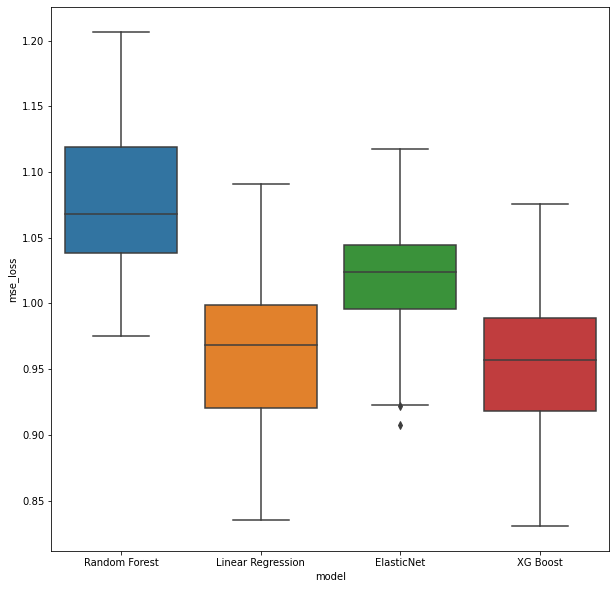

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.boxplot(x='model', y='mse_loss', data=best_results)
plt.show()


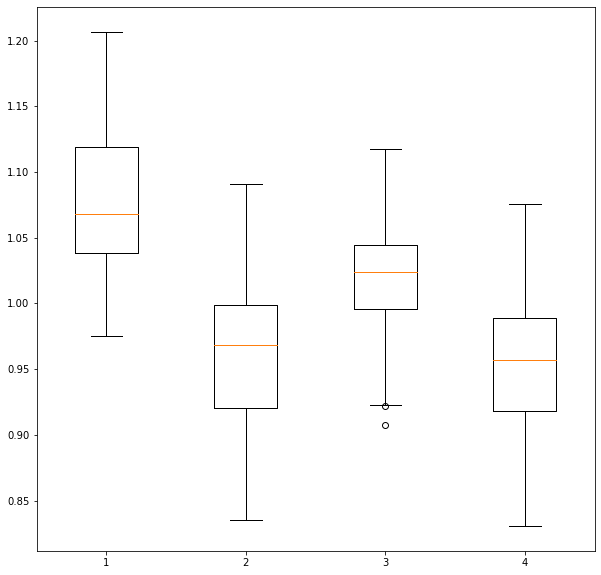

In [16]:
data = [best_results.loc[best_results['model'] == 'Random Forest', 'mse_loss'], 
best_results.loc[best_results['model'] == 'Linear Regression', 'mse_loss'], 
best_results.loc[best_results['model'] == 'ElasticNet', 'mse_loss'],
best_results.loc[best_results['model'] == 'XG Boost', 'mse_loss']]
plt.figure(figsize=(10, 10))
plt.boxplot(data)
plt.show()

### One-way ANOVA

In [17]:
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multitest import multipletests

print(anova_oneway(data=best_results['mse_loss'], groups=best_results['model'], use_var='unequal', welch_correction=True))
print(multipletests)

statistic = 50.885373193794486
pvalue = 1.303254898291264e-20
df = (3.0, 108.48421193899213)
df_num = 3.0
df_denom = 108.48421193899213
nobs_t = 200.0
n_groups = 4
means = [1.01625396 0.96435469 1.07576257 0.95454102]
nobs = [50. 50. 50. 50.]
vars_ = [0.00214305 0.00319294 0.00331763 0.002461  ]
use_var = unequal
welch_correction = True
tuple = (50.885373193794486, 1.303254898291264e-20)
<function multipletests at 0x7f539288eee0>


### Bonferroni Correction

In [18]:
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats
comp = MultiComparison(best_results['mse_loss'], best_results['model'])
test_result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
test_result[0]

<class 'statsmodels.iolib.table.SimpleTable'>

# Testset Metric

In [19]:
from sklearn.metrics import mean_squared_error
r2_rf_test = r2_score(y_pred=rf_reg.predict(test_set[feature_mask]), y_true=test_set['CRF'])
r2_linear_test = r2_score(y_pred=linear_reg.predict(test_set[feature_mask]), y_true=test_set['CRF'])
r2_elastic_test = r2_score(y_pred=elastic_reg.predict(test_set[feature_mask]), y_true=test_set['CRF'])
r2_xg_test = r2_score(y_pred=model_xgb.predict(dtest), y_true=test_set['CRF'])

mse_rf_test = mean_squared_error(y_pred=rf_reg.predict(test_set[feature_mask]), y_true=test_set['CRF'])
mse_linear_test = mean_squared_error(y_pred=linear_reg.predict(test_set[feature_mask]), y_true=test_set['CRF'])
mse_elastic_test = mean_squared_error(y_pred=elastic_reg.predict(test_set[feature_mask]), y_true=test_set['CRF'])
mse_xg_test = mean_squared_error(y_pred=model_xgb.predict(dtest), y_true=test_set['CRF'])

In [20]:
np.power(np.sum(np.power(linear_reg.predict(test_set[feature_mask]) - test_set['CRF'], 2) / 2172), 1/2)

0.9347255237515747

In [21]:
np.power(np.mean((linear_reg.predict(test_set[feature_mask]) - test_set['CRF'])), 1/2)

0.11744719273000227

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ElasticNet v.s. Random Forest: t-test independent samples with Bonferroni correction, P_val=7.775e-07 stat=-5.694e+00
Random Forest v.s. Linear Regression: t-test independent samples with Bonferroni correction, P_val=2.372e-15 stat=9.763e+00
Linear Regression v.s. XG Boost: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=9.229e-01
ElasticNet v.s. Linear Regression: t-test independent samples with Bonferroni correction, P_val=1.366e-05 stat=5.024e+00
Random Forest v.s. XG Boost: t-test independent samples with Bonferroni correction, P_val=1.269e-18 stat=1.128e+01
ElasticNet v.s. XG Boost: t-test independent samples with Bonferroni correction, P_val=2.784e-08 stat=6.431e+00


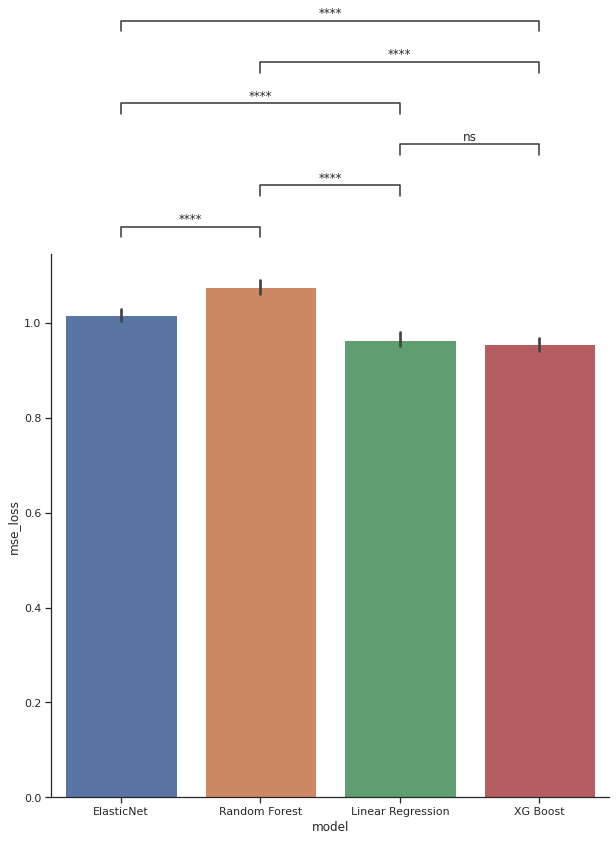

In [22]:
from statannot import add_stat_annotation
from itertools import combinations
import seaborn as sns
sns.set(style='ticks')

list_model = ["ElasticNet", "Random Forest", "Linear Regression", 'XG Boost']

oder = combinations(list_model, 2)
plt.figure(figsize=(10,10))
x = 'model'
y = 'mse_loss'
order = list(list_model)
ax = sns.barplot(data=best_results, x=x, y=y, order=order)
ax, test_results = add_stat_annotation(ax, data=best_results, x=x, y=y, order=list_model,
                                   box_pairs=oder,
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine()

In [23]:
from sklearn.metrics import mean_squared_error


metric_testset = pd.DataFrame({'model':["Random Forest", 'ElasticNet', 'Linear Regression', 'XGBoost'], 
'R^2':[r2_rf_test, r2_elastic_test, r2_linear_test, r2_xg_test], 
'mse_loss':[mse_rf_test, mse_elastic_test, mse_linear_test, mse_xg_test]})
metric_testset['Multiple Correlation'] = np.power(metric_testset['R^2'], 1/2)
metric_testset.head()

model       R^2  mse_loss  Multiple Correlation
0      Random Forest  0.214524  1.111447              0.463167
1         ElasticNet  0.237694  1.078662              0.487538
2  Linear Regression  0.275846  1.024677              0.525210
3            XGBoost  0.282602  1.015117              0.531603

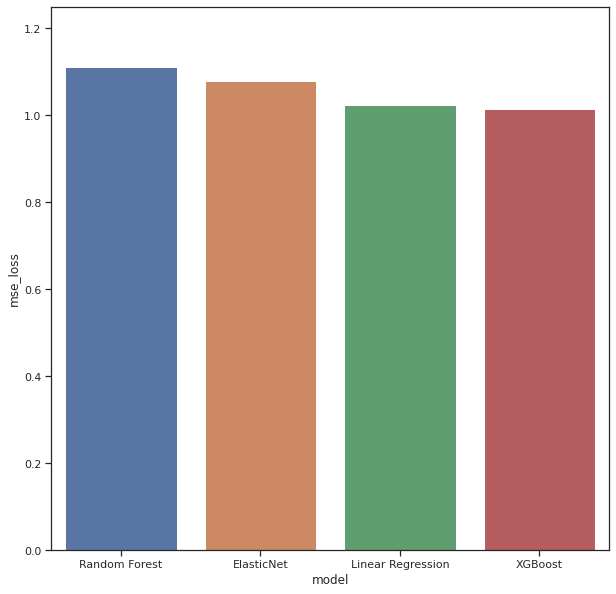

In [24]:
plt.figure(figsize=(10, 10))
sns.barplot(x='model', y='mse_loss', data=metric_testset)
plt.ylim(0, 1.25)
plt.show()

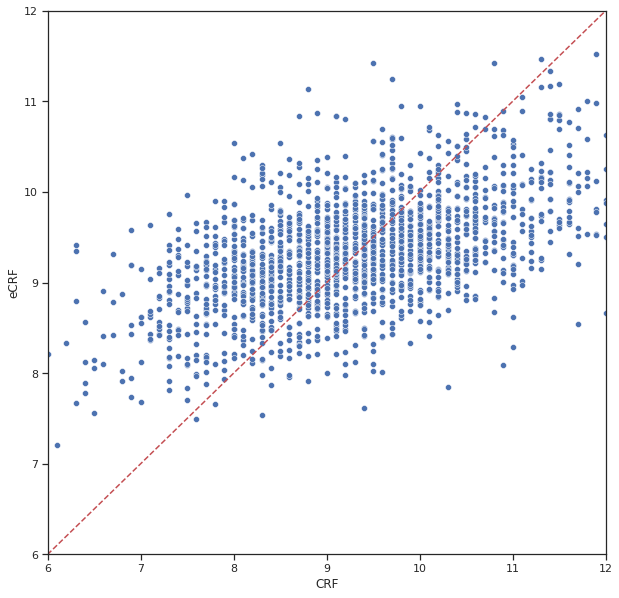

In [25]:
y_pred = model_xgb.predict(dtest)
y_true = test_set['CRF']

x = np.linspace(5, 115, 1000)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_true, y=y_pred)
plt.plot(x, x, linestyle='--', color='r')
plt.xlim((6, 12))
plt.ylim((6, 12))
plt.xlabel("CRF")
plt.ylabel("eCRF")
plt.show()

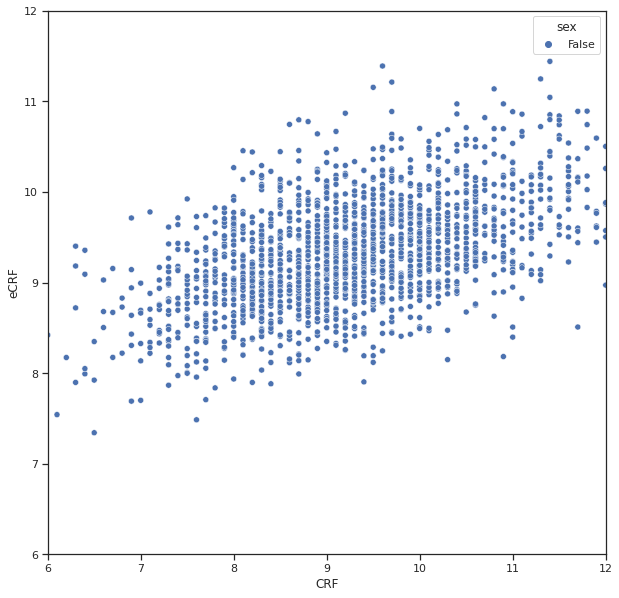

In [26]:
y_pred = linear_reg.predict(test_set[feature_mask])
y_true = test_set['CRF']

plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_true, y=y_pred, hue=test_set['sex'])
plt.xlim((6, 12))
plt.ylim((6, 12))
plt.xlabel("CRF")
plt.ylabel("eCRF")
plt.show()

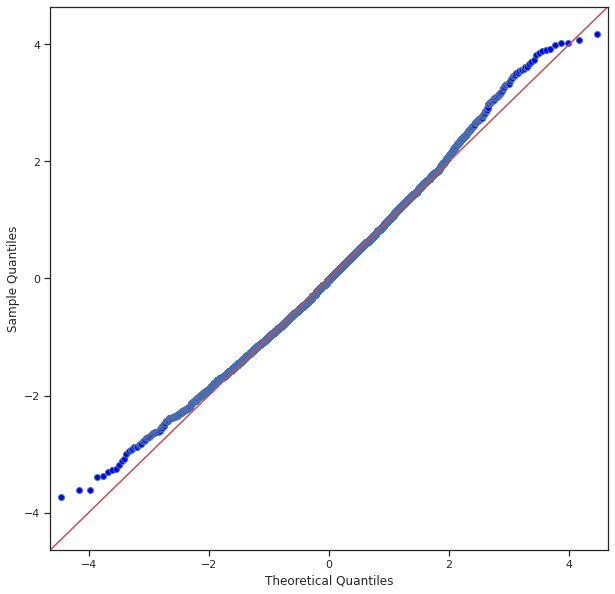

In [27]:
from statsmodels.graphics.api import qqplot
import scipy.stats as stats

f, ax = plt.subplots(1, figsize=(10,10))
qqplot((train_set['CRF']) - linear_reg.predict(train_set[feature_mask]), dist=stats.t, fit=True, line="45", ax=ax)
plt.show()

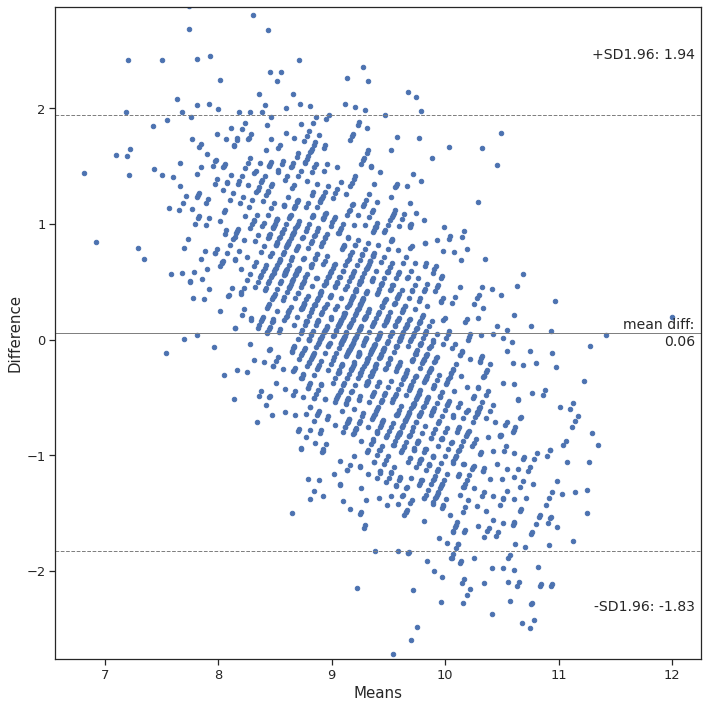

In [28]:
from statsmodels.graphics.agreement import mean_diff_plot

f, ax = plt.subplots(1, figsize=(10,10))
row_mask = ((test_set['CRF'] <= 12) & (test_set['CRF'] >= 6))
mean_diff_plot(linear_reg.predict(test_set[row_mask][feature_mask]), test_set[row_mask]['CRF'], ax=ax)
plt.show()


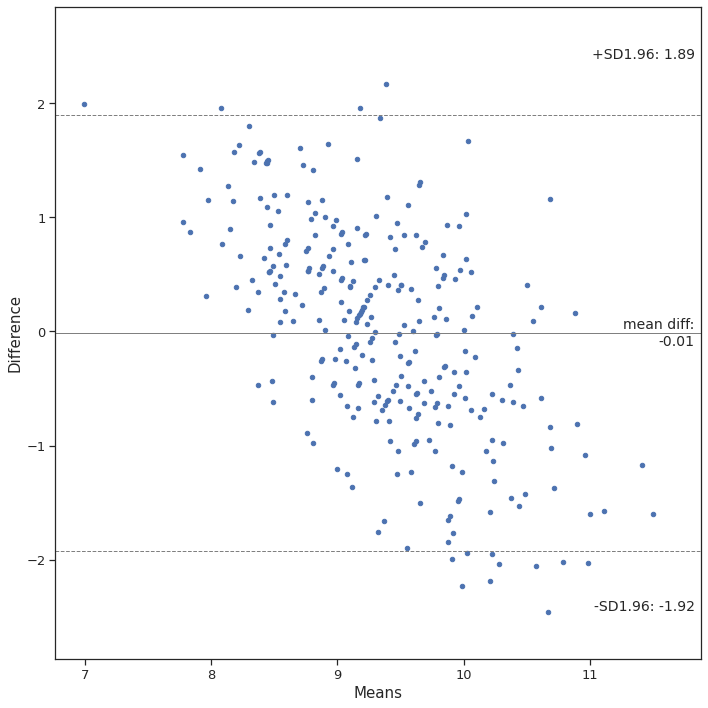

In [29]:
from statsmodels.graphics.agreement import mean_diff_plot

f, ax = plt.subplots(1, figsize=(10,10))
mean_diff_plot(linear_reg.predict(train_set.iloc[0:300][feature_mask]), train_set.iloc[0:300]['CRF'], ax=ax)
plt.show()

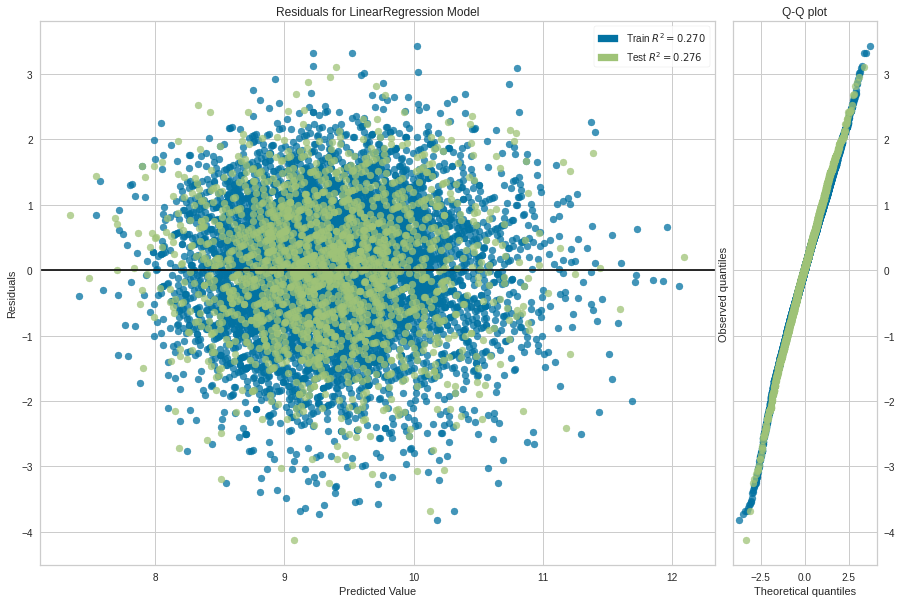

In [30]:
from yellowbrick.regressor import ResidualsPlot

diff = linear_reg.predict(X_train) - y_train
sd = np.std(diff, axis=0)
md = np.mean(diff, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
visualizer = ResidualsPlot(linear_reg, hist=False, qqplot=True, train_alpha=0.75, test_alpha=0.75, ax=ax)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

plt.show()

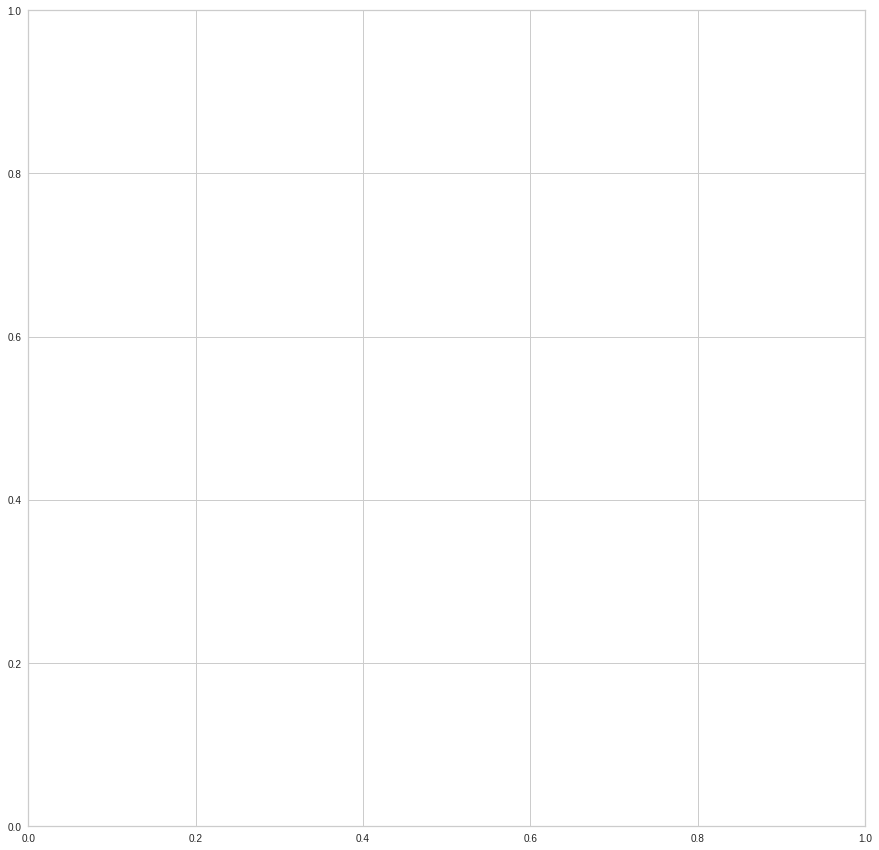

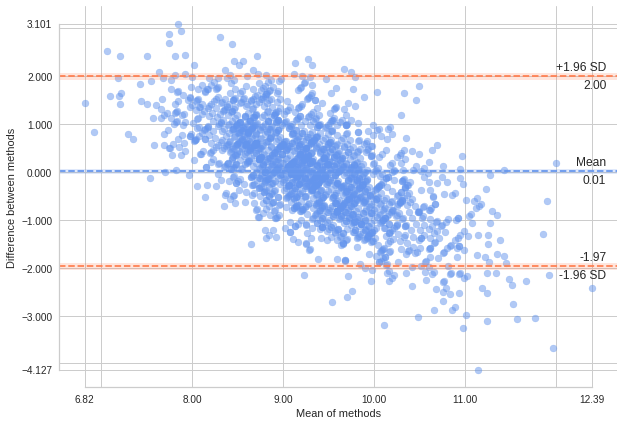

In [31]:
from pyCompare import blandAltman
ax = plt.subplots(1,1, figsize=(15, 15))
blandAltman(linear_reg.predict(X_test), y_test,
            limitOfAgreement=1.96,
            confidenceInterval=95,
            confidenceIntervalMethod='approximate',
            detrend=None,
            percentage=False)
plt.show()

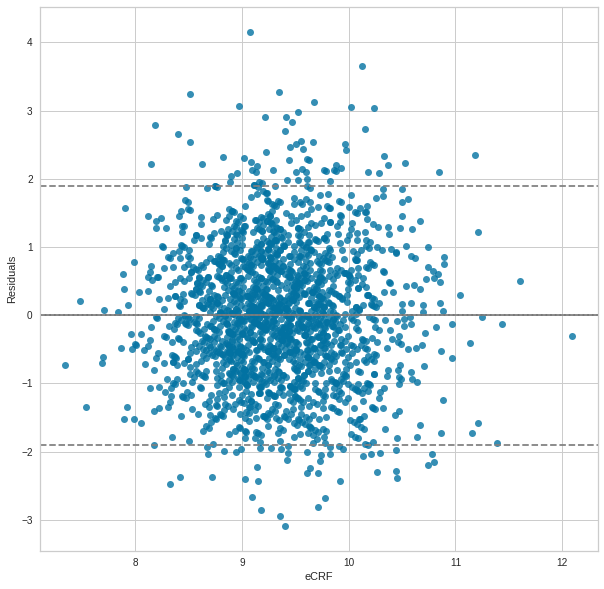

In [32]:
import seaborn as sns

diff = linear_reg.predict(X_train) - y_train
sd = np.std(diff, axis=0)
md = np.mean(diff, axis=0)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
sns.residplot(x=linear_reg.predict(X_test), y=y_test, ax=ax, robust=False)
ax.axhline(md, color="gray", linestyle='-')
ax.axhline(md + 1.96*sd, color="gray", linestyle='--')
ax.axhline(md - 1.96*sd, color="gray", linestyle='--')
plt.xlabel('eCRF')
plt.ylabel('Residuals')
plt.show()

In [33]:
best_results.groupby(['model'])['mse_loss'].apply(np.mean)

model
ElasticNet           1.016254
Linear Regression    0.964355
Random Forest        1.075763
XG Boost             0.954541
Name: mse_loss, dtype: float64

In [34]:
best_results.groupby(['model'])['mse_loss'].apply(np.std)

model
ElasticNet           0.045828
Linear Regression    0.055938
Random Forest        0.057020
XG Boost             0.049110
Name: mse_loss, dtype: float64